In [2]:
from __future__ import division

import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import sys

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/spatial/__init__.py:96: ImportWarning: Not importing directory '/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/spatial/qhull': missing __init__.py
  from .qhull import *
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/optimize/_minimize.py:37: ImportWarning: Not importing directory '/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/optimize/lbfgsb': missing __init__.py
  from .lbfgsb import _minimize_lbfgsb


## setup

In [3]:
# directory & file hierarchy
proj_dir = os.path.abspath('../../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))

## add helpers to python path
if os.path.join(proj_dir,'analysis','python') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis','python'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
# Assign variables within imported analysis helpers
import analysis_helpers as h
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)

<module 'analysis_helpers' from '/Users/megumisano/graphical_conventions/analysis/python/analysis_helpers.pyc'>

In [4]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['3dObjects']
coll = db['graphical_conventions']

# which iteration name should we use?
iterationName = 'run3_size6_waiting'

In [5]:
## get total number of stroke and clickedObj events in the collection as a whole
S = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'stroke'}]}).sort('time')
C = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'clickedObj'}]}).sort('time')
print str(S.count()) + ' stroke records in the database.'
print str(C.count()) + ' clickedObj records in the database.'

565 stroke records in the database.
144 clickedObj records in the database.


## generate group dataframe

In [6]:
## list of researcher mturk worker ID's to ignore
jefan = ['A1MMCS8S8CTWKU','A1MMCS8S8CTWKV','A1MMCS8S8CTWKS']
hawkrobe = ['A1BOIDKD33QSDK']
megsano = ['A1DVQQLVZR7W6I']
researchers = jefan + hawkrobe + megsano

In [7]:
reload(h)
## get list of all candidate games
games = coll.distinct('gameid')

## get list of complete and valid games
complete_games = h.get_complete_and_valid_games(games,coll,iterationName,researchers=researchers, tolerate_undefined_worker=False)

There are 3 complete games in total.


##### svg rendering

In [13]:
def polyline_pathmaker(lines):
    x = []
    y = []

    codes = [Path.MOVETO] # start with moveto command always
    for i,l in enumerate(lines):
        for _i,_l in enumerate(l):
            x.append(_l[0])
            y.append(_l[1])
            if _i<len(l)-1:
                codes.append(Path.CURVE4) # keep pen on page
            else:
                if i != len(lines)-1: # final vertex
                    codes.append(Path.MOVETO)
    verts = zip(x,y)            
    return verts, codes

def path_renderer(verts, codes):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    if len(verts)>0:
        path = Path(verts, codes)
        patch = patches.PathPatch(path, facecolor='none', lw=2)
        ax.add_patch(patch)
        ax.set_xlim(0,500)
        ax.set_ylim(0,500) 
        ax.axis('off')
        plt.gca().invert_yaxis() # y values increase as you go down in image
        plt.show()
    else:
        ax.set_xlim(0,500)
        ax.set_ylim(0,500)        
        ax.axis('off')
        plt.show()
    plt.savefig()
    plt.close()
    
def flatten(x):
    return [val for sublist in x for val in sublist]

In [14]:
def get_verts_and_codes(svg_list):
    '''
    parse into x,y coordinates and output list of lists of coordinates
    
    '''    
    lines = []
    Verts = []
    Codes = []
    for stroke_ind,stroke in enumerate(svg_list):
        x = []
        y = []
        parsed = parse_path(stroke)
        for i,p in enumerate(parsed):
            if i!=len(parsed)-1: # last line segment
                x.append(p.start.real)
                y.append(p.start.imag)    
            else:
                x.append(p.start.real)
                y.append(p.start.imag)     
                x.append(p.end.real)
                y.append(p.end.imag)
        lines.append(zip(x,y))
        verts, codes = polyline_pathmaker(lines)
        Verts.append(verts)
        Codes.append(codes)                  
    return Verts, Codes
    
def make_svg_list(stroke_recs):
    '''
    grab sample drawing's strokes and make a list of svg strings from it
    '''
    svg_list = []
    for single_stroke in stroke_recs:
        svg_string = single_stroke['svg']
        svg_list.append(svg_string)  
        
    return svg_list
    
    
def render_and_save(Verts,
                    Codes,
                    line_width=5,
                    imsize=8,
                    canvas_size=600,
                    game_id='GAME_ID',
                    trial_num='TRIAL_NUM',
                    category='CATEGORY'):
    
    '''
    input: 
        line_width: how wide of strokes do we want? (int)
        imsize: how big of a picture do we want? (setting the size of the figure) 
        canvas_size: original canvas size on tablet?
        out_path: where do you want to save your images? currently hardcoded below.        
    output:
        rendered sketches into nested directories
    
    '''
    ## where do you want to save your cumulative drawings?
    out_path = os.path.join('./cumulative_drawings','{}_{}'.format(game_id,age),'{}_{}'.format(trial_num,category))
    if not os.path.exists('./cumulative_drawings'):
        os.makedirs('./cumulative_drawings')
    if not os.path.exists(os.path.join('cumulative_drawings','{}_{}'.format(game_id,age))):
        os.makedirs(os.path.join('cumulative_drawings','{}_{}'.format(game_id,age)))

    verts = Verts[0]
    codes = Codes[0]
    for i,verts in enumerate(Verts):
        codes = Codes[i]
        fig = plt.figure(figsize=(imsize,imsize))    
        ax = plt.subplot(111)
        ax.axis('off')
        ax.set_xlim(0,canvas_size)
        ax.set_ylim(0,canvas_size)
        ### render sketch so far
        if len(verts)>0:
            path = Path(verts, codes)
            patch = patches.PathPatch(path, facecolor='none', lw=line_width)
            ax.add_patch(patch)
            plt.gca().invert_yaxis() # y values increase as you go down in image
#             plt.show()


        ## save out as png 
        ## maybe to make it not render every single thing, use plt.ioff
        if not os.path.exists(out_path):
            os.makedirs(out_path)
        fname = '{}_{}_{}_{}.png'.format(game_id,trial_num,category,i)
        filepath = os.path.join(out_path,fname)
        print filepath
        fig.savefig(filepath,bbox_inches='tight')
        plt.close(fig)

In [15]:
for i,g in enumerate(complete_games):    
    image_recs = coll.find({'$and': [{'gameID':g}, {'dataType':'finalImage'}]}).sort('time')    
    num_drawings = image_recs.count()
    if num_drawings > 3:
        print 'Great! Number of drawings made by this person: {}'.format(image_recs.count())        
        ### now try looping through all images made during this session and render out
        try:
            image_recs = coll.find({'$and': [{'gameId':g}, {'dataType':'finalImage'}]}).sort('time')    
            for imrec in image_recs:         
                if imrec['category'] not in practice_categories: ## don't save practice category trials
                    stroke_recs = coll.find({'$and': [
                                                      {'gameId':g}, 
                                                      {'eventType':'stroke'},
                                                      {'trialNum': imrec['trialNum']}]}).sort('time')  
                    ## check to make sure that there is at least one stroke! 
                    assert stroke_recs.count()>0

                    ## some handy metadata for writing out the sketch PNG filename
                    trial_num = stroke_recs[0]['trialNum']
                    category = stroke_recs[0]['category']
                    game_id = stroke_recs[0]['gameId']

                    ## now make an svg list!
                    svg_list = make_svg_list(stroke_recs)

                    ## now get me some verts and codes!
                    Verts, Codes = get_verts_and_codes(svg_list)

                    ## now render out your cumulative sketches and save out as pngs!
                    render_and_save(Verts,
                                    Codes,
                                    line_width=5,
                                    imsize=8,
                                    canvas_size=600,
                                    game_id=game_id,
                                    trial_num=trial_num,
                                    category=category)

        except Exception as e:
            print 'Oops, something went wrong! Here is the error:'  
            print e
            pass

In [1]:
## now actually make dataframe
GameID,TrialNum,Condition, Target, Category, Repetition, Phase, drawDuration, Outcome, Response, numStrokes, meanPixelIntensity, svgStringLength, svgStringLengthPerStroke, svgStringStd, numCurvesPerSketch, numCurvesPerStroke, timedOut, png = map(np.array, \
[GameID,TrialNum,Condition, Target, Category, Repetition, Phase, drawDuration, Outcome, Response, numStrokes, meanPixelIntensity,svgStringLength, svgStringLengthPerStroke, svgStringStd, numCurvesPerSketch, numCurvesPerStroke, timedOut,png])    

Repetition = map(int,Repetition)

D = pd.DataFrame([GameID,TrialNum,Condition, Target, Category, Repetition, Phase, drawDuration, Outcome, Response, numStrokes, meanPixelIntensity,svgStringLength, svgStringLengthPerStroke, svgStringStd, numCurvesPerSketch, numCurvesPerStroke, timedOut, png], 
                 index = ['gameID','trialNum','condition', 'target', 'category', 'repetition', 'phase', 'drawDuration', 'outcome', 'response', 'numStrokes', 'meanPixelIntensity', 'svgStringLength', 'svgStringLengthPerStroke', 'svgStringStd', 'numCurvesPerSketch', 'numCurvesPerStroke', 'timedOut', 'png'])
D = D.transpose()

## save out dataframe to be able to load in and analyze later w/o doing the above mongo querying ...
D.to_csv(os.path.join(results_dir,'graphical_conventions_group_data_{}.csv'.format(iterationName)))

# Just look at one game 
D = D[D['gameID'] == '3511-727c76f4-f755-48e9-8fc8-b61efbe785c9']

NameError: name 'np' is not defined

### confusion matrix for each category

In [156]:
reload(h)

<module 'analysis_helpers' from '/Users/megumisano/graphical_conventions/analysis/python/analysis_helpers.py'>

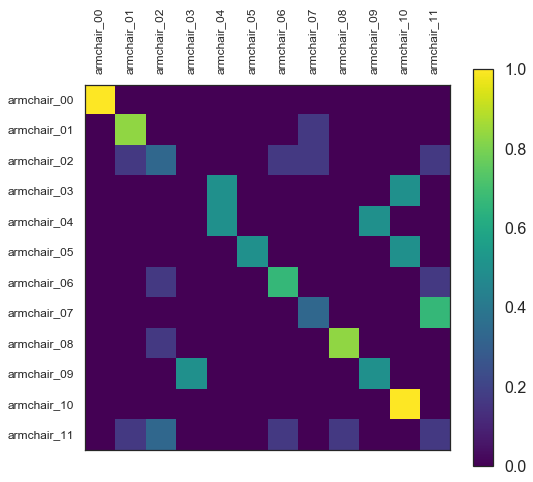

In [158]:
h.get_confusion_matrix(D, 'armchair', 6)

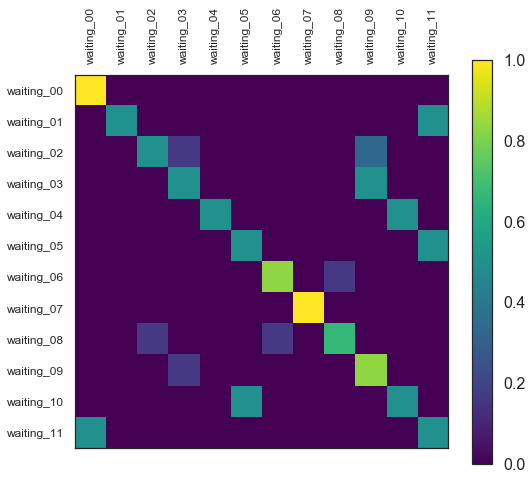

In [159]:
h.get_confusion_matrix(D, 'waiting', 6)

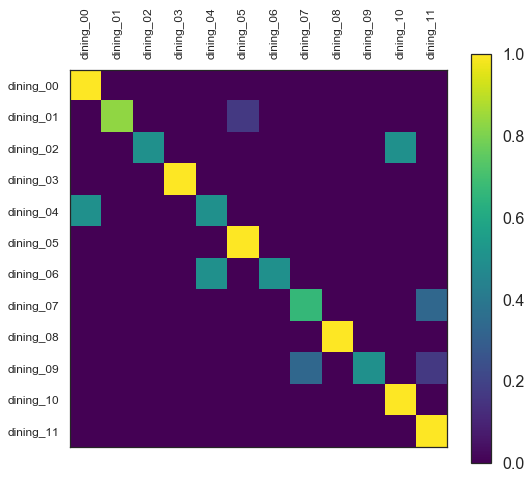

In [160]:
h.get_confusion_matrix(D, 'dining', 6)

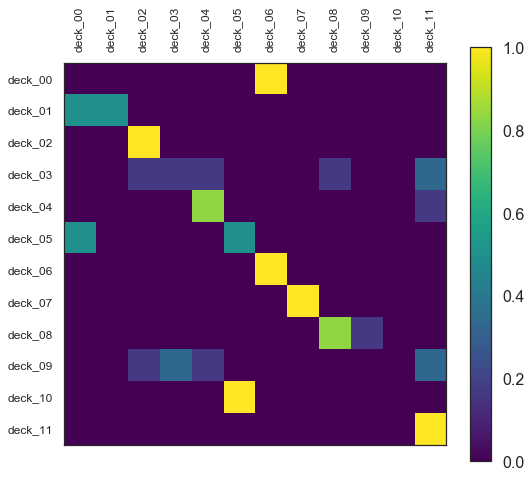

In [161]:
h.get_confusion_matrix(D, 'deck', 6)

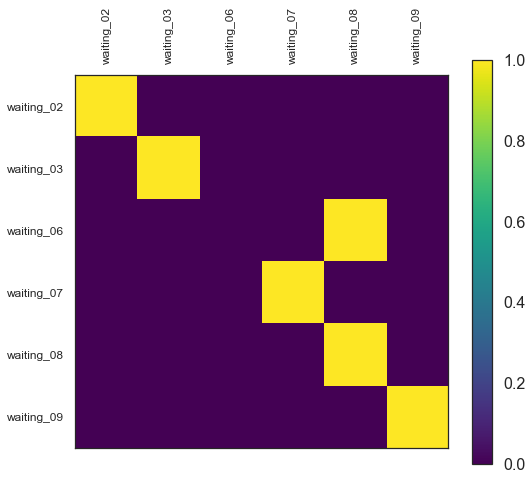

In [313]:
category = 'waiting'
set_size = 6

_D = D[D['condition'] == 'repeated']
_D = _D[_D['repetition'] >= 5]
target_list = _D['target'].tolist()
obj_list_ = []
obj_list = []
objlist = h.CATEGORY_TO_OBJECT_run2[category]
for obj in objlist[:set_size*2]:
    obj_list_.append(obj)
for i in obj_list_:
    if i in target_list:
        obj_list.append(i)

## initialize confusion matrix 
confusion = np.zeros((len(obj_list), len(obj_list)))

## generate confusion matrix by incrementing each cell 
for i, d in _D.iterrows():
    if d['category'] == category:
        targ_ind = obj_list.index(d['target'])
        chosen_ind = obj_list.index(d['response'])
        confusion[targ_ind, chosen_ind] += 1

## normalize confusion matrix 
normed = np.zeros((len(obj_list), len(obj_list)))
for i in np.arange(len(confusion)):
    normed[i,:] = confusion[i,:]/np.sum(confusion[i,:])

## plot confusion matrix 
from matplotlib import cm
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
cax = ax.matshow(normed,vmin=0,vmax=1,cmap=cm.viridis)
plt.xticks(range(len(normed)), obj_list, fontsize=12,rotation='vertical')
plt.yticks(range(len(normed)), obj_list, fontsize=12)
plt.colorbar(cax,shrink=0.8)
plt.tight_layout()
#plt.savefig('./plots/confusion_matrix_all.pdf')
#plt.close(fig)

## visualize behavioral measures over time

In [71]:
# reload analysis_helpers just to be on the safe side 
reload(h)

## set seaborn style params here
sns.set_context('poster')
sns.set_style('white')

##### Accuracy over time

In [25]:
total = 0
for outcome in D['outcome']:
    total = total + outcome 
meanAccuracy = total / len(D['outcome'])
meanAccuracy

0.79166666666666663

(0.5, 1.0)

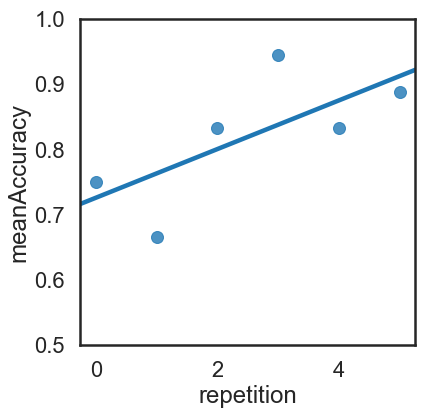

In [26]:
mean_accuracy_list = []
for i in range(0,6):
    outcome_list = (D.loc[D['repetition'] == i])['outcome']
    mean_accuracy = sum(outcome_list) / float(len(outcome_list))
    mean_accuracy_list.append(mean_accuracy)
D_mean = pd.DataFrame()
D_mean['meanAccuracy'] = mean_accuracy_list
D_mean['repetition'] = range(0,6)
D_mean
plt.figure(figsize=(6,6))
sns.regplot(data=D_mean,
         x='repetition',
         y='meanAccuracy',
         ci = None)    
plt.ylim([0.5,1.0])

In [43]:
D_correct = D[D['outcome'] == True]

In [47]:
(D_correct.groupby(['gameID','repetition','condition','category'])['numStrokes'].mean()).reset_index()

sns.lineplot(data=D_correct,
           x='repetition',
           hue='gameID',
           units='gameID',
           y=var0,
           estimator = None,
           ax=ax0,
           legend = False)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.xticks(np.arange(np.max(D0['repetition'])+1))

### plot time series during repetition phase 

##### individual measures across reps (repeated + control)

In [27]:
reload(h)
h.ts_repeated_control(D, 
                        var=dv,
                        numReps = 6,
                        limit=40, # recommended limits: 'numStrokes' : 6, 'drawDuration' : 10, 'numCurvesPerSketch' : 20, 'numCurvesPerStroke' : 6 
                        save_plot=False,
                        plot_dir=plot_dir)

NameError: name 'dv' is not defined

##### 4 measures (2x2) across reps (repeated + control) 

In [28]:
# What are the four measures that you want to visualize across reps? 
var0='numStrokes'
var1='drawDuration'
var2='numCurvesPerSketch'
var3='numCurvesPerStroke'

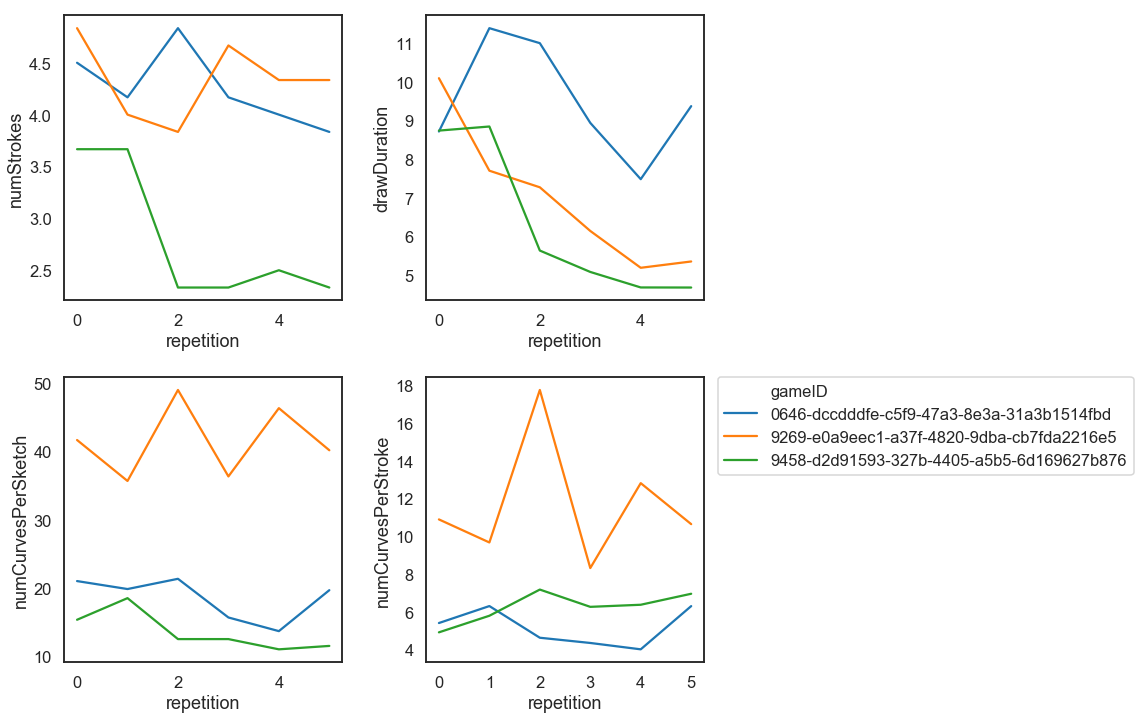

In [35]:
def convert_numeric(X,column_id):
    ## make numeric types for aggregation
    X[column_id] = pd.to_numeric(X[column_id])
    return X

###  Subhelper 1

def collapse_within_repetition(D, var, condition, numReps):
    _D = D[D['condition']==condition]
    if condition == 'repeated':
        return (_D.groupby(['gameID','repetition','condition','category'])[var].mean()).reset_index()
    else: 
        return ((_D.groupby(['gameID','repetition','condition','category'])[var].mean()).reset_index()).replace(1,numReps-1)

D = convert_numeric(convert_numeric(convert_numeric(convert_numeric(D,var0),var1),var2),var3) 

## collapsing across objects within repetition (within pair) 
## and only aggregating repeated trials into this sub-dataframe
D0 = collapse_within_repetition(D, var0, 'repeated', 6)
D1 = collapse_within_repetition(D, var1, 'repeated', 6)
D2 = collapse_within_repetition(D, var2, 'repeated', 6)
D3 = collapse_within_repetition(D, var3, 'repeated', 6)

#fig = plt.figure(figsize=(12,12))
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

## make sure that the number of timepoints now per gameID is equal to the number of repetitions in the game
num_reps = len(np.unique(D.repetition.values))
assert D0.groupby('gameID')['gameID'].count()[0]==num_reps    

sns.lineplot(data=D0,
           x='repetition',
           hue='gameID',
           units='gameID',
           y=var0,
           estimator = None,
           ax=ax0,
           legend = False)

sns.lineplot(data=D1,
           x='repetition',
           hue='gameID',
           units='gameID',
           y=var1,
           estimator = None,
           ax=ax1,
           legend = False)

sns.lineplot(data=D2,
           x='repetition',
           hue='gameID',
           units='gameID',
           y=var2,
           estimator = None,
           ax=ax2,
           legend = False)

sns.lineplot(data=D3,
           x='repetition',
           hue='gameID',
           units='gameID',
           y=var3,
           estimator = None,
           ax=ax3)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.xticks(np.arange(np.max(D0['repetition'])+1))
ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future

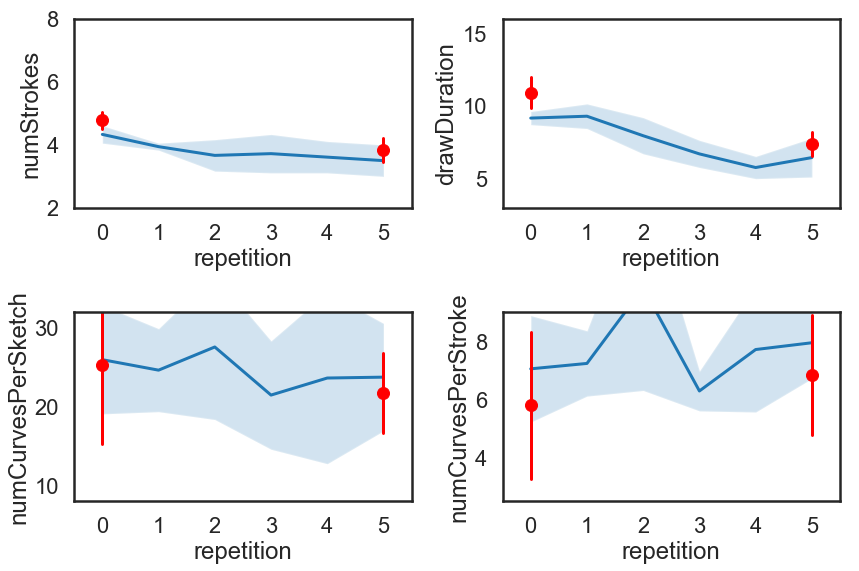

In [36]:
reload(h)
h.ts_grid_repeated_control(D, 
                                                var0, var1, var2, var3,
                                                numReps=6,
                                                 save_plot=False,
                                                 plot_dir=plot_dir)

### compare conditions in pre and post phases 

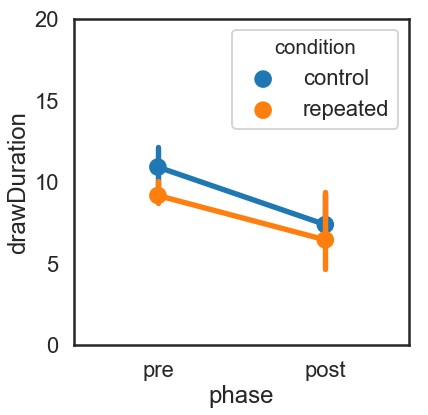

In [37]:
D1 = h.compare_conditions_prepost(D,
                                var='drawDuration',
                                limit=20,
                                save_plot=False,
                                plot_dir=plot_dir)

##### compare accuracy in pre and post phases (repeated vs control conditions)

In [38]:
for i, o in enumerate(D['outcome']):
    if o == True:
        D.set_value(i, 'outcome', 1)
    else:
        D.set_value(i, 'outcome', 0)
D['outcome'] = D['outcome'].astype(int)

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until


(0, 1.1)

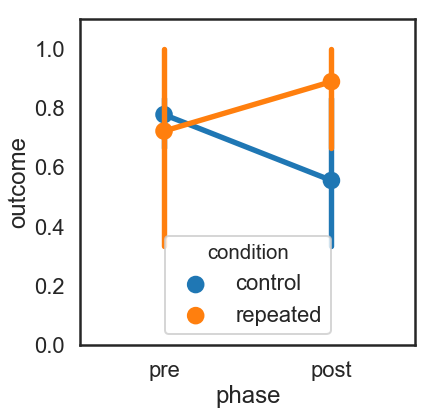

In [39]:
_D1 = D[D['phase']!='repeated'] ## exclude "repetition-phase" trials
D1 = _D1.groupby(['gameID','phase','condition'])['outcome'].mean()
D1 = D1.reset_index()    

plt.figure(figsize=(6,6))
sns.pointplot(data=D1,
         x='phase',
         y='outcome',
         hue='condition',
         order=['pre','post'])    
plt.ylim([0,1.1])
#plt.savefig(os.path.join(plot_dir,'timeseries_across_reps_{}.pdf'.format(var))) 
#return D1    

 ### visualize how sketches are changing across repetitions

In [17]:
# print_repeated_sketches(D,
#                                      complete_games,
#                                      sketch_dir)

In [18]:
# print_control_sketches(D,
#                                    complete_games,
#                                    sketch_dir)